In [34]:
!pip install utils

In [152]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import os
import utils

In [36]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


In [5]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# dataset

In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

In [12]:
! cp -r /aiffel/tensorflow_datasets /aiffel/aiffel/GoingDeeper/GD1

In [13]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [14]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [17]:
ds_info.features['label'].names

['cat', 'dog']

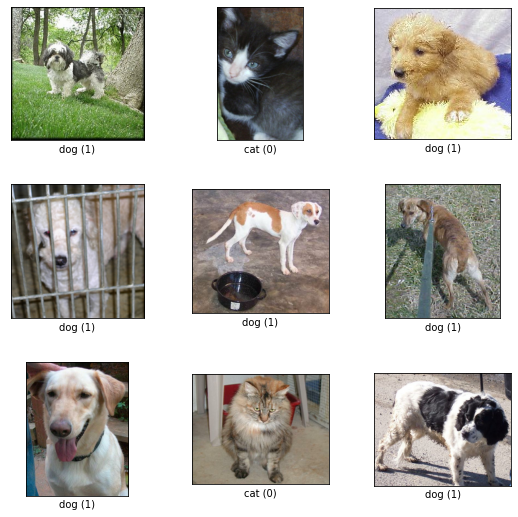

In [23]:
fig = tfds.show_examples(ds_train,ds_info)

In [24]:
def normalize_and_resize_img (image, label) :
    image = tf.image.resize(image,(224,224))
    return tf.cast(image,tf.float32) /255 , label

In [26]:
def apply_normalize_on_dataset(ds, is_test = False, batch_size =16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls =1
    )
    
    ds = ds.batch(batch_size)
    if not is_test :
        ds = ds.repeat()
        ds = ds.shuffle(100)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [28]:
BATCH_SIZE = 32
EPOCH = 15

In [29]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

# resnet 34 & resnet 50

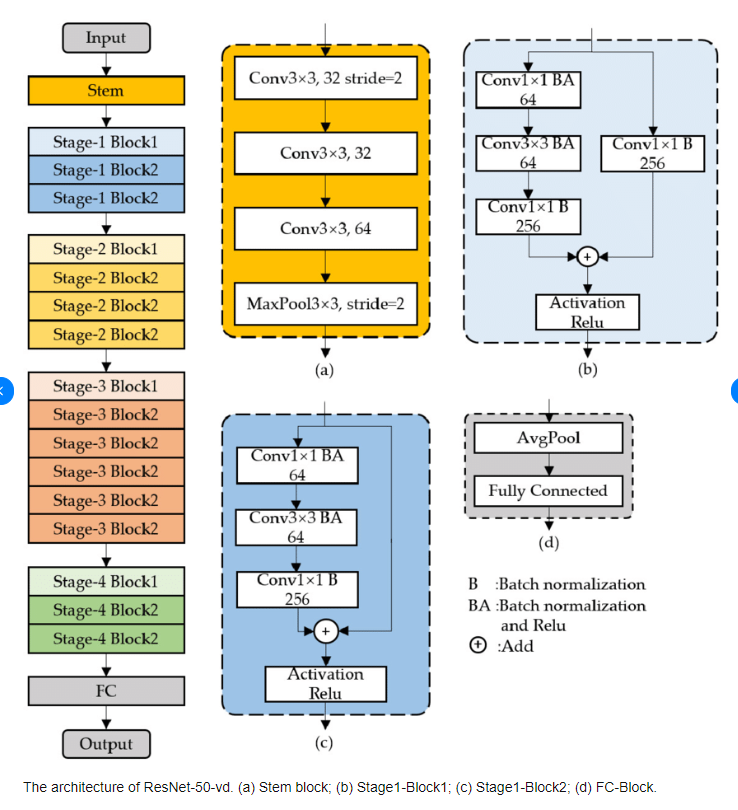

In [37]:
def conv (layer, channel, kernel_size=(3,3), strides=1, padding ='same', activation = 'relu') :
    x = keras.layers.Conv2D(filters = channel,
                           kernel_size = kernel_size,
                           kernel_initializer = 'he_normal',
                           padding = padding,
                           strides = strides)(layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation :
        x = keras.layers.Activation(activation)(x)
        
    return x

In [130]:
def residual(x, num_cnn = 3, channel = 64, is_50 = True, block_num = 0) :
    # res50
    if is_50 :
        for i in range(num_cnn) :
            if i == 0 :
                shortcut = conv(x, channel*4, (1,1), strides =2, activation = None)
                x = conv(x, channel, (1,1), strides =2)
                x = conv(x, channel, (3,3))
                x = conv(x, channel*4, (1,1), activation = None)
                
            else :
                shortcut = x
                x = conv(x, channel, (1,1))
                x = conv(x, channel, (3,3))
                x = conv(x, channel*4, (1,1), activation = None)
                
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # res34
    else :
        for i in range(num_cnn) :
            if block_num > 0 and i ==0:
                shortcut = conv(x, channel, (1,1), strides=2, activation=None)
                x = conv(x, channel, (3,3), strides=2)
                x = conv(x, channel, (3,3), activation=None)
            else :
                shortcut = x
                x = conv(x, channel)
                x = conv(x, channel, activation=None) 
        
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
        
    return x

In [131]:
def build_resnet(num_cnn_list, channel_list, is_50 =True, input_shape = (32,32,3), num_classes=1):
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape = input_shape)
    
    conv1 = conv(input_layer, 64, (7,7), strides = 2)
    res = keras.layers.MaxPooling2D((3,3), strides =2)(conv1)
    
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = residual(res, cnn, channel, is_50, block_num)
        
    output = keras.layers.GlobalAveragePooling2D()(res)
    output = keras.layers.Dense(num_classes, activation='sigmoid',kernel_initializer='he_normal')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    
    return model

In [132]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),
                         )

In [133]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3),
                         )

In [134]:
resnet_50.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_709 (Conv2D)             (None, 112, 112, 64) 9472        input_29[0][0]                   
__________________________________________________________________________________________________
batch_normalization_708 (BatchN (None, 112, 112, 64) 256         conv2d_709[0][0]                 
__________________________________________________________________________________________________
activation_640 (Activation)     (None, 112, 112, 64) 0           batch_normalization_708[0][0]    
___________________________________________________________________________________________

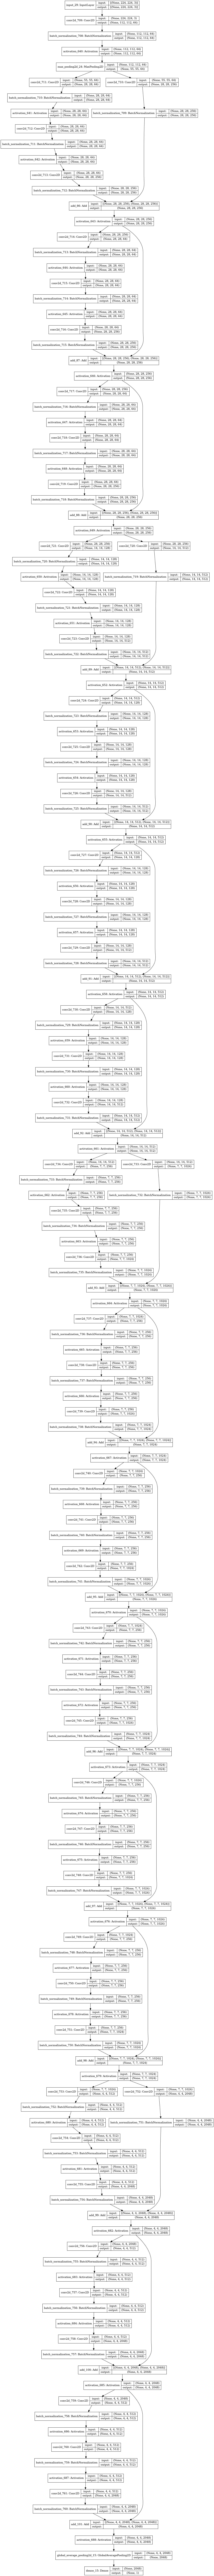

In [135]:
keras.utils.plot_model(resnet_50, show_shapes =True)

In [136]:
resnet_34.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_673 (Conv2D)             (None, 112, 112, 64) 9472        input_28[0][0]                   
__________________________________________________________________________________________________
batch_normalization_672 (BatchN (None, 112, 112, 64) 256         conv2d_673[0][0]                 
__________________________________________________________________________________________________
activation_607 (Activation)     (None, 112, 112, 64) 0           batch_normalization_672[0][0]    
___________________________________________________________________________________________

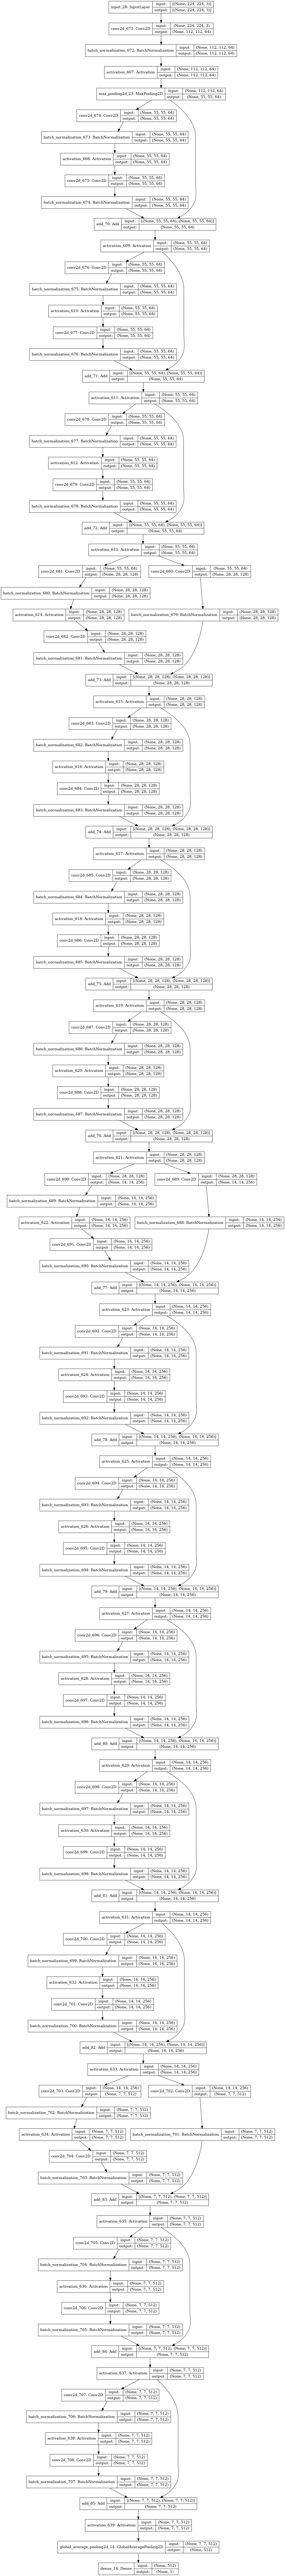

In [137]:
keras.utils.plot_model(resnet_34, show_shapes =True)

# fit and plot

In [145]:
batch_size =128
epochs = 15

In [147]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
)

Epoch 1/15
 95/145 [==================>...........] - ETA: 8s - loss: 0.6010 - accuracy: 0.6734

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


129/145 [=========================>....] - ETA: 2s - loss: 0.5977 - accuracy: 0.6720

138/145 [===========================>..] - ETA: 1s - loss: 0.5982 - accuracy: 0.6712

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.5952 - accuracy: 0.6748

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 43s 240ms/step - loss: 0.5952 - accuracy: 0.6748 - val_loss: 0.8240 - val_accuracy: 0.5269
Epoch 2/15
 69/145 [=============>................] - ETA: 13s - loss: 0.5794 - accuracy: 0.6957

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.6996

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 216ms/step - loss: 0.5793 - accuracy: 0.6996 - val_loss: 0.5959 - val_accuracy: 0.6858
Epoch 3/15
131/145 [==========================>...] - ETA: 2s - loss: 0.5678 - accuracy: 0.7016

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


141/145 [============================>.] - ETA: 0s - loss: 0.5676 - accuracy: 0.7030

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.5667 - accuracy: 0.7047

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.5667 - accuracy: 0.7047 - val_loss: 0.5717 - val_accuracy: 0.6962
Epoch 4/15
  9/145 [>.............................] - ETA: 24s - loss: 0.5474 - accuracy: 0.7083

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 36/145 [======>.......................] - ETA: 19s - loss: 0.5425 - accuracy: 0.7266

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 42/145 [=======>......................] - ETA: 18s - loss: 0.5439 - accuracy: 0.7262

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.5562 - accuracy: 0.7164

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.5562 - accuracy: 0.7164 - val_loss: 0.9042 - val_accuracy: 0.5503
Epoch 5/15
104/145 [====================>.........] - ETA: 7s - loss: 0.5278 - accuracy: 0.7378

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


141/145 [============================>.] - ETA: 0s - loss: 0.5279 - accuracy: 0.7343

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.5278 - accuracy: 0.7350

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 217ms/step - loss: 0.5278 - accuracy: 0.7350 - val_loss: 0.5562 - val_accuracy: 0.7118
Epoch 6/15
 69/145 [=============>................] - ETA: 13s - loss: 0.5310 - accuracy: 0.7251

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.5192 - accuracy: 0.7360

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.5192 - accuracy: 0.7360 - val_loss: 1.1184 - val_accuracy: 0.5547
Epoch 7/15
130/145 [=========================>....] - ETA: 2s - loss: 0.5111 - accuracy: 0.7510

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


141/145 [============================>.] - ETA: 0s - loss: 0.5115 - accuracy: 0.7504

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.5128 - accuracy: 0.7498

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.5128 - accuracy: 0.7498 - val_loss: 0.8310 - val_accuracy: 0.5807
Epoch 8/15
 13/145 [=>............................] - ETA: 23s - loss: 0.4559 - accuracy: 0.7861

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 40/145 [=======>......................] - ETA: 18s - loss: 0.5023 - accuracy: 0.7547

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 46/145 [========>.....................] - ETA: 17s - loss: 0.5044 - accuracy: 0.7520

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.7598

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.4959 - accuracy: 0.7598 - val_loss: 0.5322 - val_accuracy: 0.7465
Epoch 9/15
100/145 [===================>..........] - ETA: 7s - loss: 0.4881 - accuracy: 0.7653

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


131/145 [==========================>...] - ETA: 2s - loss: 0.4793 - accuracy: 0.7698

143/145 [============================>.] - ETA: 0s - loss: 0.4764 - accuracy: 0.7719

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.7720

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.4765 - accuracy: 0.7720 - val_loss: 0.8832 - val_accuracy: 0.6128
Epoch 10/15
 73/145 [==============>...............] - ETA: 12s - loss: 0.4767 - accuracy: 0.7723

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.4677 - accuracy: 0.7761

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.4677 - accuracy: 0.7761 - val_loss: 0.5454 - val_accuracy: 0.7370
Epoch 11/15
135/145 [==========================>...] - ETA: 1s - loss: 0.4352 - accuracy: 0.7963

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.4327 - accuracy: 0.7998

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.4327 - accuracy: 0.7998 - val_loss: 0.6761 - val_accuracy: 0.7144
Epoch 12/15
  1/145 [..............................] - ETA: 25s - loss: 0.4178 - accuracy: 0.7500

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 12/145 [=>............................] - ETA: 23s - loss: 0.4249 - accuracy: 0.8021

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 39/145 [=======>......................] - ETA: 18s - loss: 0.4305 - accuracy: 0.7869

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 45/145 [========>.....................] - ETA: 17s - loss: 0.4326 - accuracy: 0.7868

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.4373 - accuracy: 0.7912

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.4373 - accuracy: 0.7912 - val_loss: 0.5160 - val_accuracy: 0.7500
Epoch 13/15
102/145 [====================>.........] - ETA: 7s - loss: 0.4152 - accuracy: 0.8125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


134/145 [==========================>...] - ETA: 1s - loss: 0.4202 - accuracy: 0.8074

144/145 [============================>.] - ETA: 0s - loss: 0.4182 - accuracy: 0.8071

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.4178 - accuracy: 0.8073

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.4178 - accuracy: 0.8073 - val_loss: 0.4864 - val_accuracy: 0.7656
Epoch 14/15
 75/145 [==============>...............] - ETA: 12s - loss: 0.3923 - accuracy: 0.8283

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8248

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.3950 - accuracy: 0.8248 - val_loss: 0.4668 - val_accuracy: 0.7743
Epoch 15/15
136/145 [===========================>..] - ETA: 1s - loss: 0.4014 - accuracy: 0.8148

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.3983 - accuracy: 0.8168

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.3983 - accuracy: 0.8168 - val_loss: 0.4631 - val_accuracy: 0.7821


In [148]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_34.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
)

Epoch 1/15
 98/145 [===================>..........] - ETA: 8s - loss: 0.3408 - accuracy: 0.8540

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


128/145 [=========================>....] - ETA: 3s - loss: 0.3475 - accuracy: 0.8479

138/145 [===========================>..] - ETA: 1s - loss: 0.3462 - accuracy: 0.8478

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.8474

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 34s 212ms/step - loss: 0.3471 - accuracy: 0.8474 - val_loss: 0.5687 - val_accuracy: 0.7439
Epoch 2/15
 67/145 [============>.................] - ETA: 13s - loss: 0.3452 - accuracy: 0.8428

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.8494

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 213ms/step - loss: 0.3463 - accuracy: 0.8494 - val_loss: 0.4735 - val_accuracy: 0.7795
Epoch 3/15
130/145 [=========================>....] - ETA: 2s - loss: 0.3646 - accuracy: 0.8399

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


141/145 [============================>.] - ETA: 0s - loss: 0.3647 - accuracy: 0.8384

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.3628 - accuracy: 0.8394

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 32s 222ms/step - loss: 0.3628 - accuracy: 0.8394 - val_loss: 0.5004 - val_accuracy: 0.7795
Epoch 4/15
  9/145 [>.............................] - ETA: 24s - loss: 0.3296 - accuracy: 0.8576

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 36/145 [======>.......................] - ETA: 19s - loss: 0.3683 - accuracy: 0.8438

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 42/145 [=======>......................] - ETA: 18s - loss: 0.3705 - accuracy: 0.8378

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.8539

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 213ms/step - loss: 0.3426 - accuracy: 0.8539 - val_loss: 0.5619 - val_accuracy: 0.7700
Epoch 5/15
100/145 [===================>..........] - ETA: 7s - loss: 0.3049 - accuracy: 0.8634

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


129/145 [=========================>....] - ETA: 2s - loss: 0.3101 - accuracy: 0.8639

141/145 [============================>.] - ETA: 0s - loss: 0.3099 - accuracy: 0.8644

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.8638

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.3114 - accuracy: 0.8638 - val_loss: 0.5329 - val_accuracy: 0.7613
Epoch 6/15
 71/145 [=============>................] - ETA: 13s - loss: 0.2967 - accuracy: 0.8750

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.8780

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.2911 - accuracy: 0.8780 - val_loss: 0.5806 - val_accuracy: 0.7656
Epoch 7/15
131/145 [==========================>...] - ETA: 2s - loss: 0.2738 - accuracy: 0.8848

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


143/145 [============================>.] - ETA: 0s - loss: 0.2803 - accuracy: 0.8822

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.8817

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.2808 - accuracy: 0.8817 - val_loss: 0.5023 - val_accuracy: 0.7856
Epoch 8/15
  9/145 [>.............................] - ETA: 24s - loss: 0.2317 - accuracy: 0.9062

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 36/145 [======>.......................] - ETA: 19s - loss: 0.2518 - accuracy: 0.8924

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 42/145 [=======>......................] - ETA: 18s - loss: 0.2612 - accuracy: 0.8862

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.2815 - accuracy: 0.8811

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 211ms/step - loss: 0.2815 - accuracy: 0.8811 - val_loss: 0.7807 - val_accuracy: 0.7196
Epoch 9/15
 99/145 [===================>..........] - ETA: 8s - loss: 0.2318 - accuracy: 0.9069

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


132/145 [==========================>...] - ETA: 2s - loss: 0.2314 - accuracy: 0.9051

144/145 [============================>.] - ETA: 0s - loss: 0.2319 - accuracy: 0.9034

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.9028

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.2324 - accuracy: 0.9028 - val_loss: 1.3726 - val_accuracy: 0.6215
Epoch 10/15
 73/145 [==============>...............] - ETA: 12s - loss: 0.2236 - accuracy: 0.9114

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9103

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.2192 - accuracy: 0.9103 - val_loss: 0.5641 - val_accuracy: 0.7830
Epoch 11/15
133/145 [==========================>...] - ETA: 2s - loss: 0.2130 - accuracy: 0.9135

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9121

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.2140 - accuracy: 0.9121 - val_loss: 0.6147 - val_accuracy: 0.7543
Epoch 12/15
  1/145 [..............................] - ETA: 25s - loss: 0.2946 - accuracy: 0.8750

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 12/145 [=>............................] - ETA: 23s - loss: 0.2500 - accuracy: 0.8906

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 39/145 [=======>......................] - ETA: 18s - loss: 0.2300 - accuracy: 0.9054

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 45/145 [========>.....................] - ETA: 17s - loss: 0.2275 - accuracy: 0.9042

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9133

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.2138 - accuracy: 0.9133 - val_loss: 0.7236 - val_accuracy: 0.7639
Epoch 13/15
103/145 [====================>.........] - ETA: 7s - loss: 0.1841 - accuracy: 0.9248

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


134/145 [==========================>...] - ETA: 1s - loss: 0.1795 - accuracy: 0.9270

145/145 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9274

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.1797 - accuracy: 0.9274 - val_loss: 0.8766 - val_accuracy: 0.7222
Epoch 14/15
 73/145 [==============>...............] - ETA: 12s - loss: 0.1755 - accuracy: 0.9315

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9341

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.1643 - accuracy: 0.9341 - val_loss: 0.7944 - val_accuracy: 0.7760
Epoch 15/15
136/145 [===========================>..] - ETA: 1s - loss: 0.1441 - accuracy: 0.9409

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.9388

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


145/145 [==============================] - 31s 212ms/step - loss: 0.1472 - accuracy: 0.9388 - val_loss: 0.9479 - val_accuracy: 0.7569


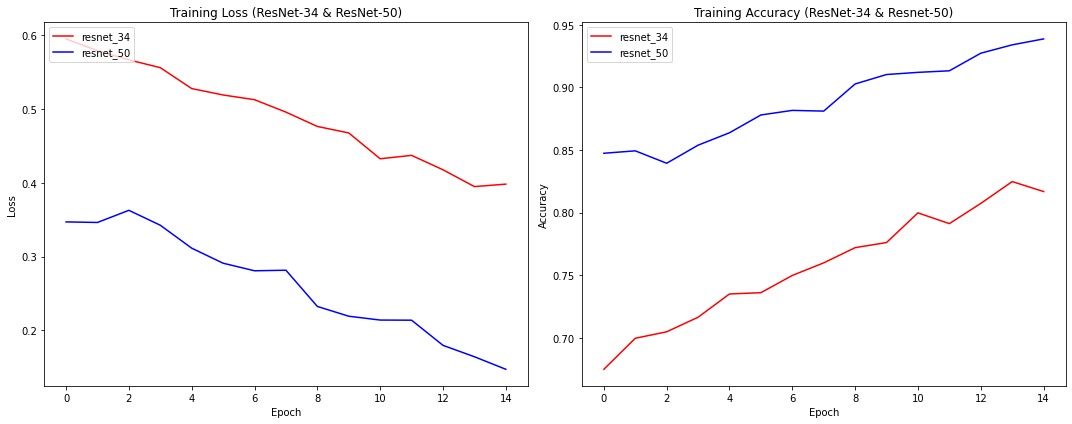

In [149]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Training Loss 시각화
plt.subplot(121)
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Training Loss (ResNet-34 & ResNet-50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')

# ResNet-34, Plain-34 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_34.history['accuracy'], 'r')
plt.plot(history_50.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-34 & Resnet-50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장


plt.show()

In [150]:
model_result = {
    'resnet 34' : [
        round(np.array(history_34.history['loss']).mean(), 2),
        round(np.array(history_34.history['accuracy']).mean(), 2),
        round(np.array(history_34.history['val_loss']).mean(), 2),
        round(np.array(history_34.history['val_accuracy']).mean(), 2)
    ],
    
    'resnet 50' : [
        round(np.array(history_50.history['loss']).mean(), 2),
        round(np.array(history_50.history['accuracy']).mean(), 2),
        round(np.array(history_50.history['val_loss']).mean(), 2),
        round(np.array(history_50.history['val_accuracy']).mean(), 2)
    ]
}

In [153]:
df_model_result = pd.DataFrame(model_result, index=['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])
df_model_result

resnet 34  resnet 50
Training Loss             0.49       0.26
Training Accuracy         0.76       0.89
Validation Loss           0.66       0.69
Validation Accuracy       0.68       0.75

# 회고 

warning 없애는 거 try, except, import warning 다했는데 안되네

파일 손실 된 거는 어떻게 고치지

add 시 shape 맞추기 위해 stride 넣긴 했는데 맞는지 모르겠네

다른 방법은 없나?